# Analysis of SEIRX model runs for vaccination prevalence

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import analysis_functions as af
import seaborn as sns

In [2]:
language = 'english' # English or German
vaccination_ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
index_cases = ['employee', 'resident']

## Analysis B.1.1.7

### Data loading and wrangling

In [3]:
res_path = '../data/simulation_results'
dst_path = '../plots'
N_runs = 5000
sim_name = 'simulations_vaccination_rate_UK_variant_{}.csv'.format(N_runs)

In [4]:
data = pd.read_csv(join(res_path, sim_name))

data = data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio'])

### Plot heatmap

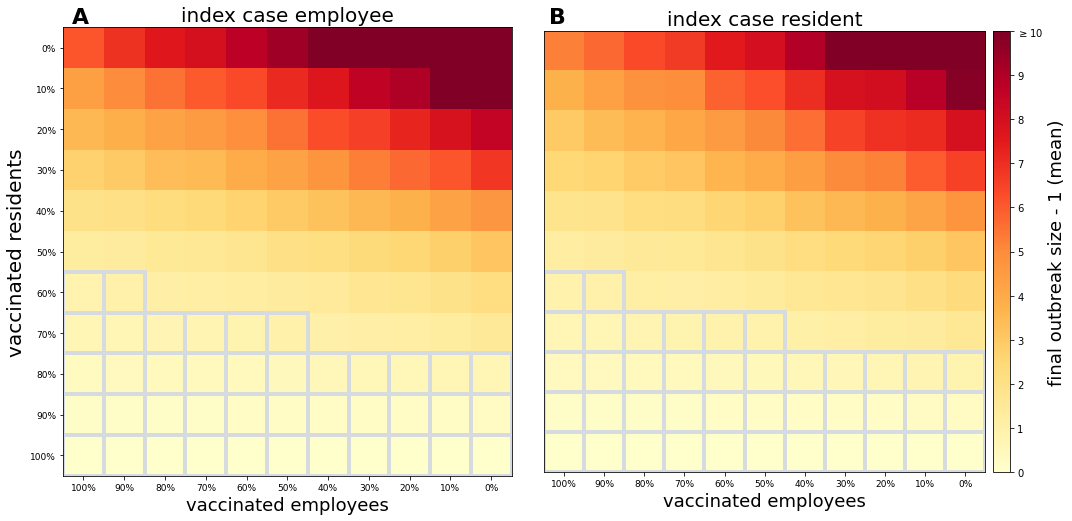

In [5]:
metric = 'infected_residents_mean'
af.plot_vaccination_heatmap(data, metric, vaccination_ratios, language, 
                            variant='_UK_variant')

### Plot employee vaccination

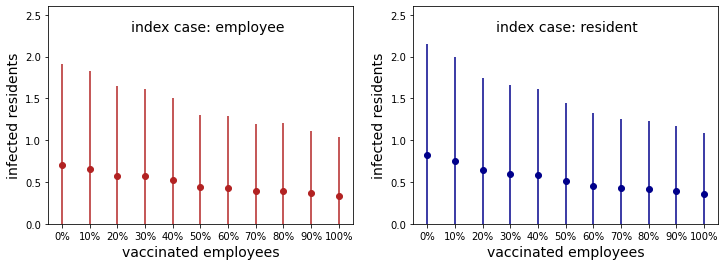

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['FireBrick', 'DarkBlue']

for index_case, ax, color in zip(index_cases, axes, colors):
    subset = data.loc[index_case, :, 0.8].copy()
    if index_case == 'resident':
        subset['infected_residents_mean'] -= 1
    ax.errorbar(subset.index.get_level_values('employee_vaccination_ratio') * 100, 
                subset['infected_residents_mean'], color=color,
                yerr=subset['infected_residents_std'], fmt='o')
    
    ax.text(25, 2.3, 'index case: {}'.format(index_case), fontsize=14)
    ax.set_ylim(0, 2.6)
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
    xticks = range(0, 101, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{}%'.format(i) for i in xticks])
    ax.set_xlabel('vaccinated employees', fontsize=14)
    ax.set_ylabel('infected residents', fontsize=14)
    #ax.plot([-2, 102], [0.5, 0.5], '--', color='grey')
    
plt.savefig('../plots/employee_vaccination_rate_UK_variant_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/employee_vaccination_rate_UK_variant_{}.png'.format(language[0:3]))

### Outbreak sizes

#### Employee 50%, resident 0%

In [7]:
mean = data.loc['employee', 0.5, 0.0]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

9.3682 +- 9.7362614856804


In [8]:
mean = data.loc['resident', 0.5, 0.0]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.9765999999999995 +- 9.244952475229598


#### Employee 0%, resident 50%

In [9]:
mean = data.loc['employee', 0.0, 0.5]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.1316 +- 4.079756159633123


In [10]:
mean = data.loc['resident', 0.0, 0.5]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.1338 +- 3.9929796314616297


#### Employee 0%, resident 90%

In [11]:
mean = data.loc['employee', 0.0, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2522 +- 0.5598730673735914


In [12]:
mean = data.loc['resident', 0.0, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2822 +- 0.5914669277527909


#### Employee 50%, resident 90%

In [13]:
mean = data.loc['employee', 0.5, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1744 +- 0.4508051519858789


In [14]:
mean = data.loc['resident', 0.5, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.19619999999999993 +- 0.4772327631481774


#### Employee 90%, resident 90%

In [15]:
mean = data.loc['employee', 0.9, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1344 +- 0.3882869986989929


In [16]:
mean = data.loc['resident', 0.9, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.14139999999999997 +- 0.4067420900590017


## Analysis wild type

### Data loading and wrangling

In [17]:
res_path = '../data/simulation_results'
dst_path = '../plots'
N_runs = 5000
sim_name = 'simulations_vaccination_rate_{}.csv'.format(N_runs)

In [18]:
data = pd.read_csv(join(res_path, sim_name))

data = data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio'])

### Plot heatmap

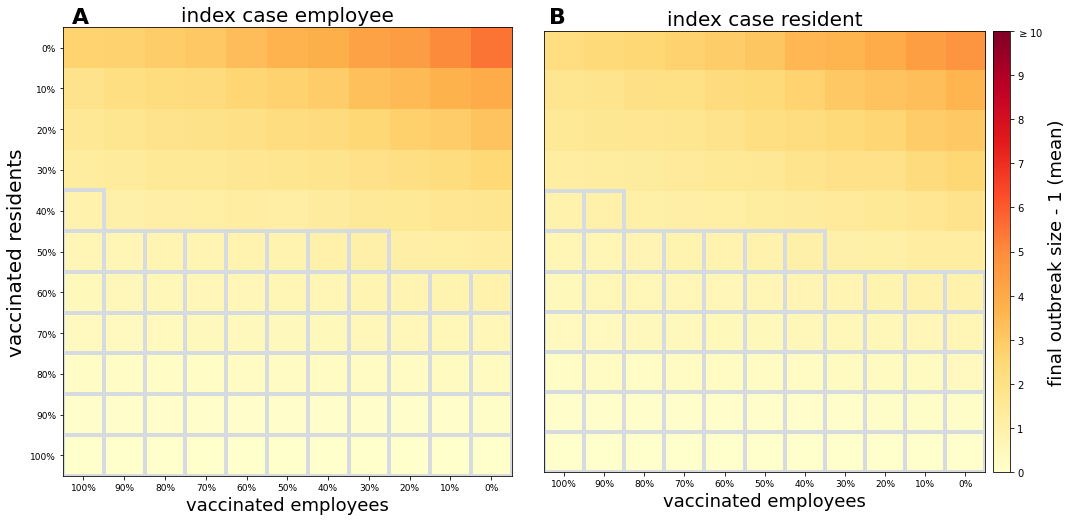

In [19]:
metric = 'infected_residents_mean'
af.plot_vaccination_heatmap(data, metric, vaccination_ratios, language, 
                            variant='')

### Plot employee vaccination

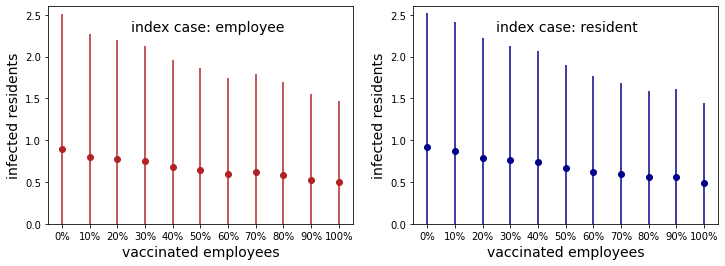

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['FireBrick', 'DarkBlue']

for index_case, ax, color in zip(index_cases, axes, colors):
    subset = data.loc[index_case, :, 0.6].copy()
    if index_case == 'resident':
        subset['infected_residents_mean'] -= 1
    ax.errorbar(subset.index.get_level_values('employee_vaccination_ratio') * 100, 
                subset['infected_residents_mean'], color=color,
                yerr=subset['infected_residents_std'], fmt='o')
    
    ax.text(25, 2.3, 'index case: {}'.format(index_case), fontsize=14)
    ax.set_ylim(0, 2.6)
    ax.set_yticks([0, 0.5, 1, 1.5, 2.0, 2.5])
    xticks = range(0, 101, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{}%'.format(i) for i in xticks])
    ax.set_xlabel('vaccinated employees', fontsize=14)
    ax.set_ylabel('infected residents', fontsize=14)
    #ax.plot([-2, 102], [0.5, 0.5], '--', color='grey')
    
plt.savefig('../plots/employee_vaccination_rate_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/employee_vaccination_rate_{}.png'.format(language[0:3]))

### Outbreak sizes

#### Employee 50%, resident 0%

In [21]:
mean = data.loc['employee', 0.5, 0.0]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.694 +- 5.35829322277647


In [22]:
mean = data.loc['resident', 0.5, 0.0]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.1136 +- 4.828515087642403


#### Employee 0%, resident 50%

In [23]:
mean = data.loc['employee', 0.0, 0.5]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2326 +- 2.153560959193167


In [24]:
mean = data.loc['resident', 0.0, 0.5]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2448000000000001 +- 2.087712784109392


#### Employee 50%, resident 90%

In [25]:
mean = data.loc['employee', 0.5, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1004 +- 0.3363665686326432


In [26]:
mean = data.loc['resident', 0.5, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.11220000000000008 +- 0.3453042238395011


#### Employee 90%, resident 90%

In [27]:
mean = data.loc['employee', 0.9, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0854 +- 0.3106865707252983


In [28]:
mean = data.loc['resident', 0.9, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.08939999999999992 +- 0.3114916458094531


## Analysis B.1.1.7 & employee masks

### Data loading and wrangling

In [29]:
res_path = '../data/simulation_results'
dst_path = '../plots'
N_runs = 5000
sim_name = 'simulations_vaccination_rate_masks_{}.csv'.format(N_runs)

In [30]:
data = pd.read_csv(join(res_path, sim_name))

data = data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio'])

### Plot heatmap

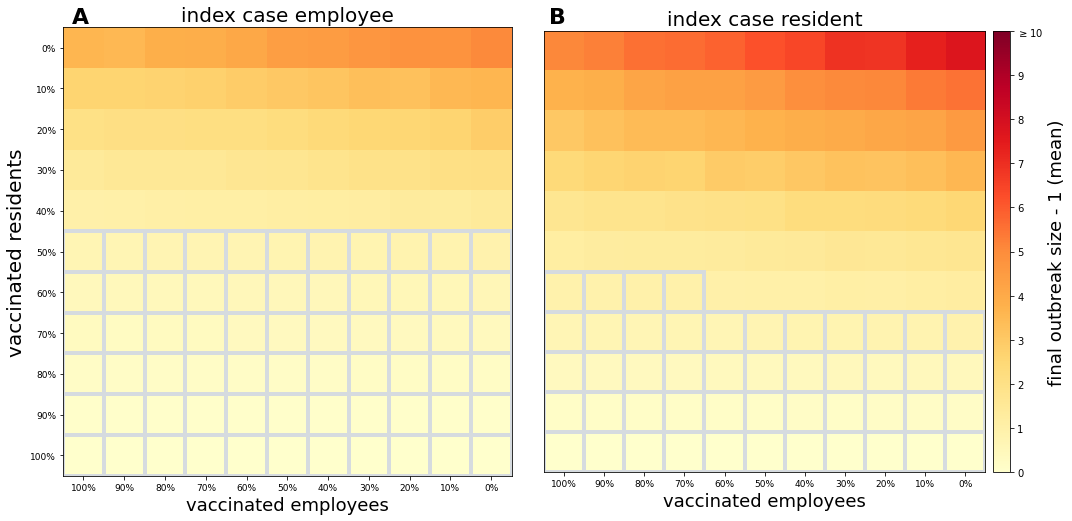

In [31]:
metric = 'infected_residents_mean'
af.plot_vaccination_heatmap(data, metric, vaccination_ratios, language, 
                            variant='_masks')

### Plot employee vaccination

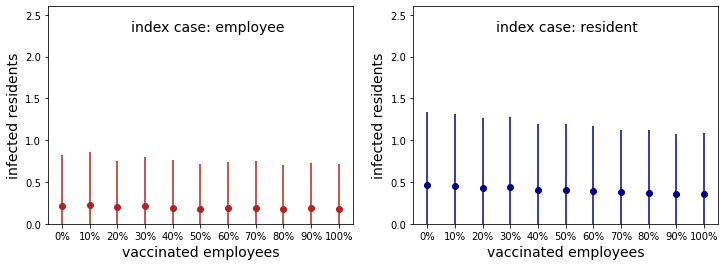

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['FireBrick', 'DarkBlue']

for index_case, ax, color in zip(index_cases, axes, colors):
    subset = data.loc[index_case, :, 0.8].copy()
    if index_case == 'resident':
        subset['infected_residents_mean'] -= 1
    ax.errorbar(subset.index.get_level_values('employee_vaccination_ratio') * 100, 
                subset['infected_residents_mean'], color=color,
                yerr=subset['infected_residents_std'], fmt='o')
    
    ax.text(25, 2.3, 'index case: {}'.format(index_case), fontsize=14)
    ax.set_ylim(0, 2.6)
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
    xticks = range(0, 101, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{}%'.format(i) for i in xticks])
    ax.set_xlabel('vaccinated employees', fontsize=14)
    ax.set_ylabel('infected residents', fontsize=14)
    #ax.plot([-2, 102], [0.5, 0.5], '--', color='grey')
    
plt.savefig('../plots/employee_vaccination_rate_masks_{}.pdf'.format(language[0:3]))
plt.savefig('../plots/employee_vaccination_rate_masks_{}.png'.format(language[0:3]))

### Outbreak sizes

#### Employee 50%, resident 0%

In [33]:
mean = data.loc['employee', 0.5, 0.0]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.3754 +- 7.188574960448865


In [34]:
mean = data.loc['resident', 0.5, 0.0]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.0]['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.2072 +- 7.661331957399594


#### Employee 0%, resident 50%

In [35]:
mean = data.loc['employee', 0.0, 0.5]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8768 +- 1.8754000066751115


In [36]:
mean = data.loc['resident', 0.0, 0.5]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.5]['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.71 +- 2.513237607679491


#### Employee 0%, resident 90%

In [37]:
mean = data.loc['employee', 0.0, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.0, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0756 +- 0.2889659846211204


In [38]:
mean = data.loc['resident', 0.0, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.0, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1594 +- 0.4257086862833731


#### Employee 50%, resident 90%

In [39]:
mean = data.loc['employee', 0.5, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0678 +- 0.27643886067038


In [40]:
mean = data.loc['resident', 0.5, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.5, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.15100000000000002 +- 0.4096737317833578


#### Employee 90%, resident 90%

In [41]:
mean = data.loc['employee', 0.9, 0.9]['infected_residents_mean']
std = data.loc['employee', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0638 +- 0.2678505344063296


In [42]:
mean = data.loc['resident', 0.9, 0.9]['infected_residents_mean'] - 1
std = data.loc['resident', 0.9, 0.9]['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.14480000000000004 +- 0.4057904547653083
